## Model 3: Random Forest
* ~~Logistic Regression~~
* <i><b>Random Forests:</b> with Grid Search</i>
* Naïve Bayes
* SVM

#### Model Performance Summary 
Random Forests accuracy for test vs train sets shows very overfit model, even with optimized hyperparameters over a gridsearch, and worse performance than Logistic Regression and Count Vectorizer. 

Model   | Transformer       | Classifier            | $n$  | x-val   | Train    | Test   |  Precision    | Specificity  | Recall
---     |---                | ---                   | ---  | ---     | ---      | ---    |  ---          | ---          | ---
1*      | Count Vectorizer  | Logistic Regressor    | 2605 | 0.7373  | 0.9723   | 0.7515 | 0.7436        | 0.7179       | 0.7838 
2*      | Count Vectorizer  | Logistic Regressor    | 4537 | 0.7111  | 0.9568   | 0.7436 | 0.7527        | 0.7496       | 0.7396
3       | Count Vectorizer  | Random Forest	        | 4537 | 0.7569  | 0.9855   | 0.7154 | 0.7126        | 0.696        |0.7325

In [1]:
##### BASIC IMPORTS 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##### MODELLING IMPORTS 
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

##### VECTOR MODELLING IMPORTS 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text   # TO MODIFY STOP WORDS 

from sklearn.metrics import accuracy_score

In [2]:
# CUSTOM IMPORTS AND SETTINGS 
plt.style.use('gstyle.mplstyle')                        # stylesheet for sns
color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',         # colorlist, color blind pallet
                  '#f781bf', '#a65628', '#984ea3',      # from gist.github.com/thriveth/8560036
                  '#999999', '#e41a1c', '#dede00']

sns.set_palette(sns.color_palette(color_cycle))         # setting custom palette

pd.options.display.max_columns = 90                     # view settings
pd.options.display.max_rows = 100

In [5]:
# importing clean file output from model 2 
df = pd.read_csv('../data/reddit_2000_clean.csv')
df.dropna(axis=0, inplace = True)
df.head()

,corpus,class
0,if you look around there are lots of horror st...,1
1,just to close on this tesla replaced the latch...,1
2,it pays to be a tesla owner,1
3,its happening a sub too will try and cross pos...,1
4,dat gullwing mmmm,1


### MODELING

In [6]:
# start X, y 
# NOTE: CountVectorizer requires a vector, so make sure you set X to be a pandas Series, not a DataFrame.
X = df['corpus']
y = df['class']

#### Pre-processing
Using same `stop_words` list to ensure subreddit title and closely-associated terms are not used in model. 

In [7]:
reddit_stopwords = ['porsche', 'tesla', 'taycan', 'model', 'car', 'xplaid', 'turbo']
stopwords = text.ENGLISH_STOP_WORDS.union(reddit_stopwords)

#### Random Forest Classifier 

In [8]:
# REMINDER: baseline
y.value_counts(normalize = True)  

1    0.507205
0    0.492795
Name: class, dtype: float64

In [9]:
# train-test split
# can use "class_weights = " if we want 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

#### Grid and Pipe Setup, Fit, Score

In [10]:
pipe = Pipeline([                                           
    ('cvec', CountVectorizer(stop_words=stopwords)),                            
    ('rf', RandomForestClassifier(n_estimators=100))        
])

In [14]:
pipe_params = {
    'cvec__max_df': [0.7, 0.8, .9, .95],
    'cvec__max_features': [3000, 4000, 5000, 7000],
    'cvec__min_df': [2, 3],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'cvec__stop_words': [stopwords],
    'rf__max_depth': [None, 1, 2, 3, 4, 5],
    'rf__n_estimators': [100, 150, 200],
    'rf__n_jobs': [-1], 
}

In [15]:
# Instantiate GridSearchCV object
gs = GridSearchCV(pipe, pipe_params, cv = 3)

In [16]:
# FIT gs 
gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',
                                                                              'almost',
                                                            

In [2]:
# ### all accuracy metrics 
# x= ['x-val', 'RF Train', 'RF Test']
# model_mets = [ 
#     gs.best_score_,                 # estimate with x-val
#     gs.score(X_train, y_train),     # train score 
#     gs.score(X_test, y_test)      # test score 
#      ]
# model_mets

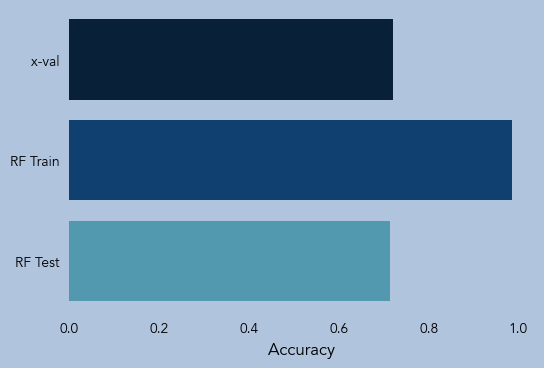

In [20]:
f, ax = plt.subplots(figsize=(6, 4))
ax.tick_params(bottom=False, left = False)  # remove the ticks
plt.xlabel('Accuracy')

sns.despine(left=True, bottom=True)
sns.barplot(y = x, x = model_mets, palette='ocean')
plt.show()

In [3]:
# gs.best_estimator_.feature_importances_
#gs.best_params_

In [22]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [23]:
# precision, specificity, recall 
class_mets = [
    round(tp/(tp + fp), 4),
    round(tn/(tn + fp), 4), 
    round(tp/(tp + fn), 4)
]
class_mets

# higher recall means more Teslas were correcctly IDed, and lower specificity shows better classification for Taycan

[0.7126, 0.696, 0.7325]

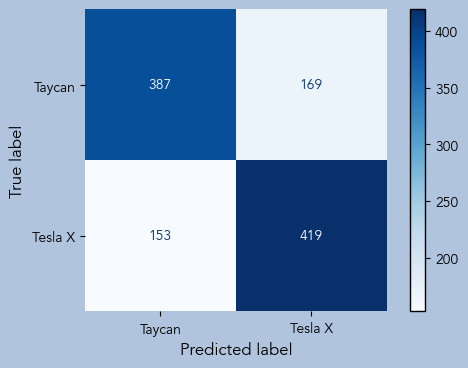

In [24]:
sub_1 = "Tesla X"
sub_2 = "Taycan"

plot_confusion_matrix(gs, X_test, y_test, cmap = 'Blues', display_labels = [sub_2, sub_1]);
(sns.despine(left=True, bottom=True))

In [28]:
mask = (y_test != preds) & (preds == 0)
false_negatives = pd.DataFrame(X_test[mask])

# exporting missed comments to analyse
df.to_csv('../data/missed03.txt', index = False)

false_negatives[:40]

,corpus
2136,hi all im wanting to join the community i hav...
547,yeah the performance version has white seats w...
48,thank you
2124,hello am out of options so i figured i would t...
375,yea last night
920,you can dial in the settings more deliberately...
1376,it kind of baffles me these cars have been sit...
1498,i have the yakima i like it i highly recommend...
2166,the windows in my model x go up and down abou...
663,nice leaderboard uspiro at nices urepliesnic...
